In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [10]:
class Shower:
    def show_img(
        img_mtx: np.ndarray,
        extra_img_params: dict = {},
        in_gray: bool = True,
        is_show: bool = True,
        title: str = None,
        figsize: tuple = None,
        in_brg: bool = True
    ):
        '''
            cmap='gray': display the image in grayscale
        '''
        img_mtx_cp = img_mtx.copy()
        if in_brg and in_gray is False:
            img_mtx_cp = img_mtx_cp[:, :, ::-1]

        if in_gray:
            img_params = {'X': img_mtx_cp} | {'cmap': 'gray'} | extra_img_params
        else:
            img_params = {'X': img_mtx_cp} | extra_img_params

        if figsize is not None:
            plt.figure(figsize=figsize)

        plt.imshow(**img_params)
        plt.axis('off')

        if title:
            plt.title(title)

        if is_show:
            plt.show()


    def show_two_img(
        img_mtx1: np.ndarray, 
        img_mtx2: np.ndarray,
        title_img1: str = None,
        title_img2: str = None,
        extra_img1_params: dict = {},
        extra_img2_params: dict = {},
        figsize: tuple=(8, 12)
    ):
        plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        Shower.show_img(img_mtx1, extra_img1_params, is_show=False)
        if title_img1:
            plt.title(title_img1)

        plt.subplot(1, 2, 2)
        Shower.show_img(img_mtx2, extra_img2_params, is_show=False)
        if title_img2:
            plt.title(title_img2)

        plt.tight_layout() # fit into the figure area without overlapping
        plt.show()

In [11]:
PICTURES_PATH = 'materials/imgs/'

 # Пример с использованием OpenCV

In [12]:
PICTURE1_PATH = PICTURES_PATH + 'street_1.jpeg'
PICTURE2_PATH = PICTURES_PATH + 'street_2.jpeg'

PICTURE1_PATH, PICTURE2_PATH

('materials/imgs/street_1.jpeg', 'materials/imgs/street_2.jpeg')

In [13]:
def stitch_images(images):
    """Производит операцию по склеиванию изображений."""
    # Создается объект класса Stitcher
    stitcher = cv2.Stitcher_create()

    # Операция склеивания выполняется методом stitch
    _ , result = stitcher.stitch(images)

    return result


In [14]:
# Шаг 1: Загрузка изображений
img1 = cv2.imread(PICTURE1_PATH)
img2 = cv2.imread(PICTURE2_PATH)

if img1 is None or img2 is None:
    raise FileNotFoundError("Одно из изображений не найдено.")

# Шаг 2: Преобразование в градации серого
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


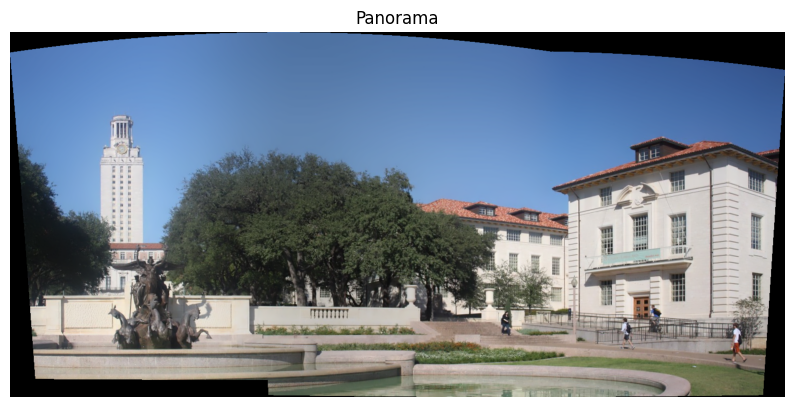

In [15]:
result = stitch_images([img1, img2])

# Отображение результата
Shower.show_img(
    cv2.cvtColor(result, cv2.COLOR_BGR2RGB),
    figsize=(10, 5),
    title='Panorama'
)


 # Пример с использованием SIFT метода для отбора ключевых точек

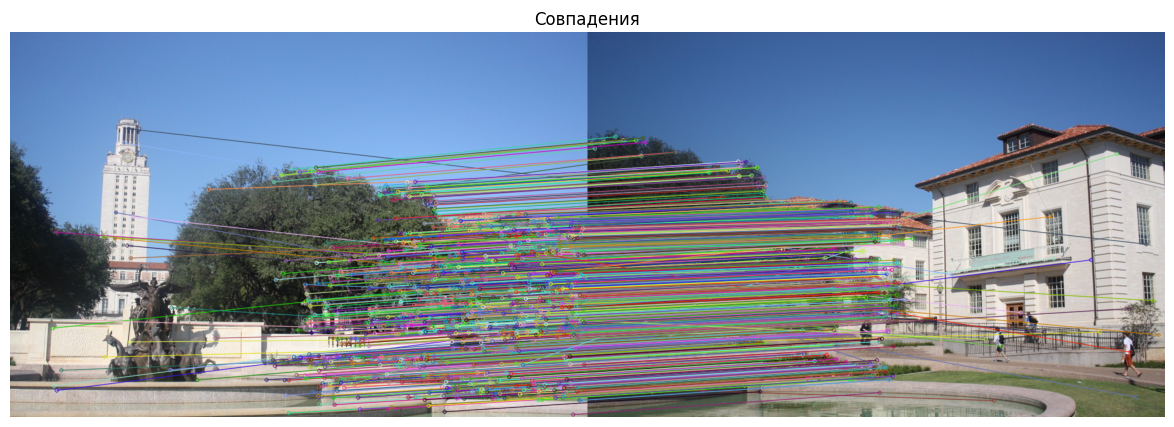

In [16]:
# Загрузка изображений и создание панорамы
# подумать о том, важен ли порядок - первое изображение то, что слева или наоборот?

img1 = cv2.imread(PICTURE1_PATH)
img2 = cv2.imread(PICTURE2_PATH)

if img1 is None or img2 is None:
    raise FileNotFoundError("Одно из изображений не найдено.")

# Шаг 1: Преобразование в градации серого
# (Для упрощения обработки изображений и поиска ключевых точек преобразуем изображения в оттенки серого с помощью)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Шаг 2: Инициализация SIFT и обнаружение ключевых точек
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Шаг 3: Использование FLANN для быстрого сопоставления дескрипторов между ключевыми точками
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Шаг 4: Фильтрация совпадений с использованием правила "доброго соседа"
# Проверяется как расстояние "похожести" между ключевыми точками,
# так и их количество
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Порог фильтрации
        good_matches.append(m)

# Проверка достаточного количества совпадений
if len(good_matches) < 10:
    raise ValueError("Недостаточно совпадений для построения панорамы.")

# Визуализация совпадений (опционально) через matplotlib
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
Shower.show_img(
    cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB),
    figsize=(15, 5),
    title='Совпадения'
)



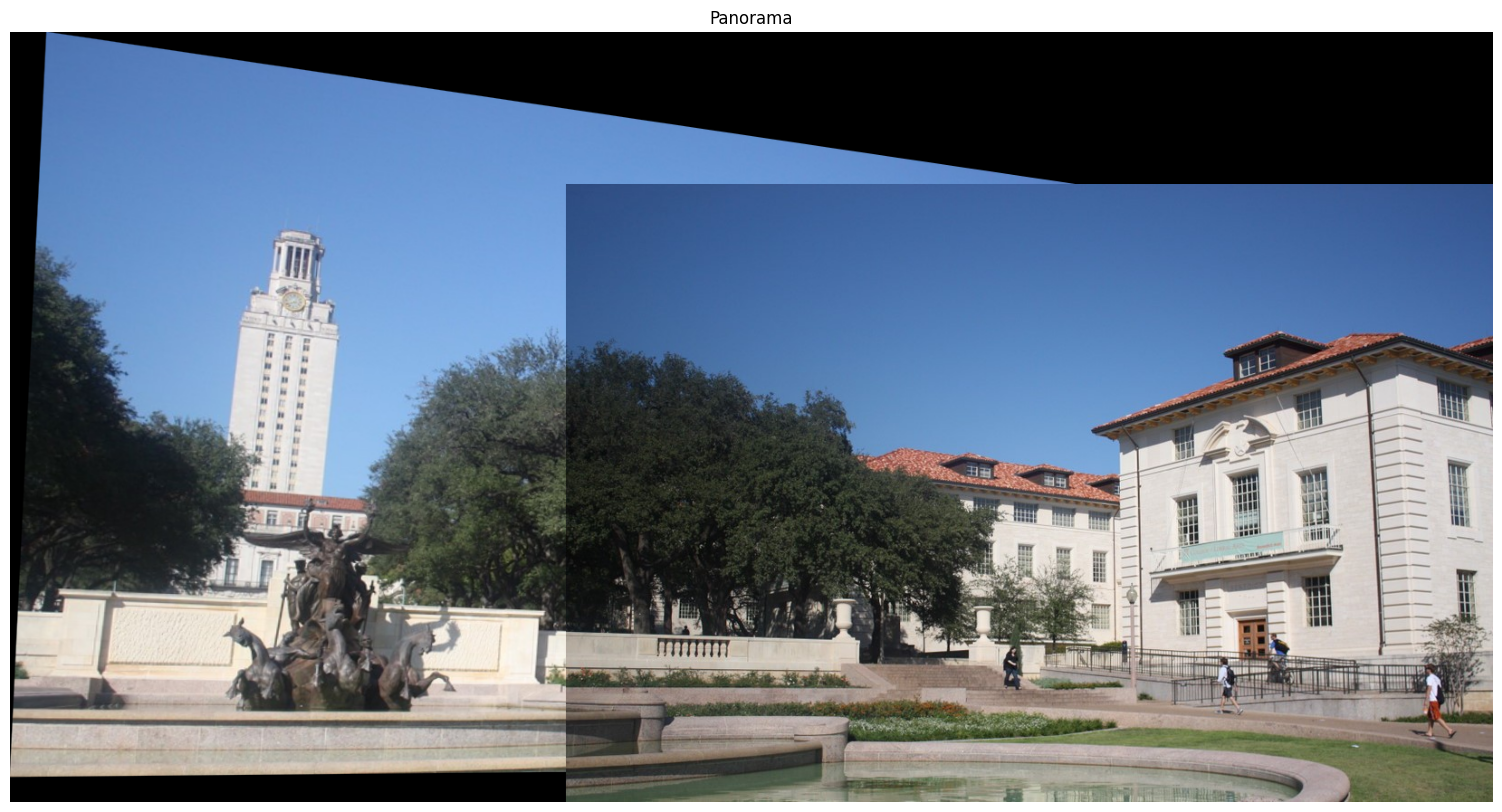

In [17]:
# Шаг 5: Получение координат точек (из совпавших дескрипторов извлекаем координаты ключевых точек)
src_pts = np.float32(
    [kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32(
    [kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Шаг 6: Построение матрицы гомографии (Гомография описывает, как одно изображение трансформируется, чтобы соответствовать другому)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Шаг 7: Вычисление размеров результирующего изображения
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

points_img2 = np.float32(
    [[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
points_img1 = np.float32(
    [[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)

# С помощью гомографии трансформируем углы второго изображения
transformed_points = cv2.perspectiveTransform(points_img2, H)
all_points = np.concatenate((points_img1, transformed_points), axis=0)

# Объединяем углы первого и второго изображений, чтобы определить размеры результирующего изображения
[x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
[x_max, y_max] = np.int32(all_points.max(axis=0).flatten())

translation_dist = [-x_min, -y_min]
result_width = x_max - x_min
result_height = y_max - y_min

# Шаг 8: Создаём трансляционную матрицу и корректируем матрицу гомографии
# Добавляем смещение, чтобы избежать отрицательных координат при трансформации
translation_matrix = np.array(
    [[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
H = translation_matrix @ H

# Шаг 9: Преобразуем первое изображение с помощью cv2.warpPerspective, используя матрицу гомографии
# В результирующее изображение добавляем второе изображение без изменений
# Накладываем второе изображение в заданные границы
panorama = cv2.warpPerspective(img1, H, (result_width, result_height))
panorama[translation_dist[1]:translation_dist[1] + height2,
         translation_dist[0]:translation_dist[0] + width2] = img2

# Отображение результата
Shower.show_img(
    cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB),
    figsize=(20, 10),
    title='Panorama'
)


 # ДЗ: Реализация класса пайплайна по созданию панорам

 Напишите функцию или класс для реализации метода создания панорамы по двум изображениям. Функция должна принимать на вход путь к изображениям и выдавать результат панорамы, который затем можно использовать (не только вывести на экран но и реализовать возврат для передачи панорамы в другие переменные для работы). Приведите примеры по паре изображений выше а также по паре изображений mountain_*.jpg.

In [18]:
PICTURE3_PATH = PICTURES_PATH + 'mountain_1.jpg'
PICTURE4_PATH = PICTURES_PATH + 'mountain_2.jpg'

PICTURE3_PATH, PICTURE4_PATH

('materials/imgs/mountain_1.jpg', 'materials/imgs/mountain_2.jpg')

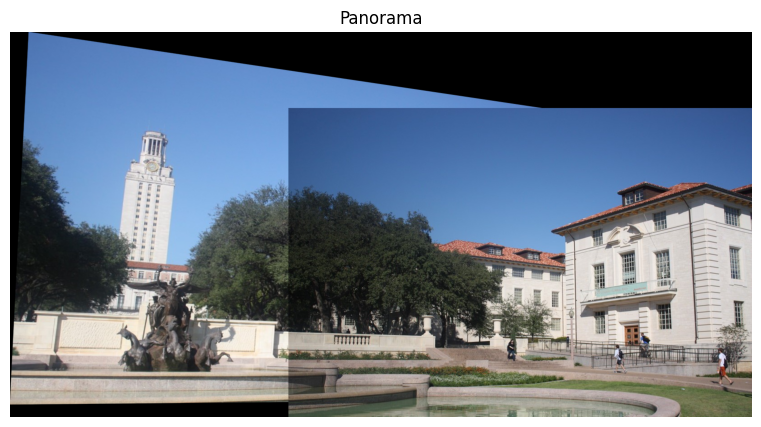

In [19]:
class PanoramsCreator:
    FIGSIZES = (10, 5)

    @classmethod
    def _sift(cls, img1, img2, is_print_steps):
        # Шаг 1: Преобразование в градации серого
        # (Для упрощения обработки изображений и поиска ключевых точек преобразуем изображения в оттенки серого)
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        # Шаг 2: Инициализация SIFT и обнаружение ключевых точек
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(gray1, None)
        kp2, des2 = sift.detectAndCompute(gray2, None)

        # Шаг 3: Использование FLANN для быстрого сопоставления дескрипторов между ключевыми точками
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Шаг 4: Фильтрация совпадений с использованием правила "доброго соседа"
        # Проверяется как расстояние "похожести" между ключевыми точками,
        # так и их количество
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:  # Порог фильтрации
                good_matches.append(m)

        # Проверка достаточного количества совпадений
        if len(good_matches) < 10:
            raise ValueError(
                "Недостаточно совпадений для построения панорамы.")

        if is_print_steps:
            # Визуализация совпадений
            img_matches = cv2.drawMatches(
                img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            Shower.show_img(
                cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB),
                figsize=cls.FIGSIZES,
                title='Совпадения'
            )

        return kp1, kp2, good_matches


    @classmethod
    def _custom_stitch(
        cls,
        img1: np.ndarray,
        img2: np.ndarray,
        is_print_steps: bool
    ):
        kp1, kp2, good_matches = cls._sift(img1, img2, is_print_steps)

        # Шаг 5: Получение координат точек (из совпавших дескрипторов извлекаем координаты ключевых точек)
        src_pts = np.float32(
            [kp1[m.queryIdx].pt for m in good_matches]
        ).reshape(-1, 1, 2)
        dst_pts = np.float32(
            [kp2[m.trainIdx].pt for m in good_matches]
        ).reshape(-1, 1, 2)

        # Шаг 6: Построение матрицы гомографии (Гомография описывает, как одно изображение трансформируется, чтобы соответствовать другому)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Шаг 7: Вычисление размеров результирующего изображения
        height1, width1 = img1.shape[:2]
        height2, width2 = img2.shape[:2]

        points_img2 = np.float32(
            [[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
        points_img1 = np.float32(
            [[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)

        # С помощью гомографии трансформируем углы второго изображения
        transformed_points = cv2.perspectiveTransform(points_img2, H)
        all_points = np.concatenate((points_img1, transformed_points), axis=0)

        # Объединяем углы первого и второго изображений, чтобы определить размеры результирующего изображения
        [x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
        [x_max, y_max] = np.int32(all_points.max(axis=0).flatten())

        translation_dist = [-x_min, -y_min]
        result_width = x_max - x_min
        result_height = y_max - y_min

        # Шаг 8: Создаём трансляционную матрицу и корректируем матрицу гомографии
        # Добавляем смещение, чтобы избежать отрицательных координат при трансформации
        translation_matrix = np.array(
            [[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]]
        )
        H = translation_matrix @ H

        # Шаг 9: Преобразуем первое изображение с помощью cv2.warpPerspective, используя матрицу гомографии
        # В результирующее изображение добавляем второе изображение без изменений
        # Накладываем второе изображение в заданные границы
        img2_resized = cv2.resize(img2, (width1, height2))
        panorama = cv2.warpPerspective(img1, H, (result_width, result_height))
        panorama[
            translation_dist[1]:translation_dist[1] + height2,
            translation_dist[0]:translation_dist[0] + width2
        ] = img2_resized

        return panorama


    @classmethod
    def _opencv_stitch(
        cls,
        img1: np.ndarray,
        img2: np.ndarray
    ):
        # Создается объект класса Stitcher
        stitcher = cv2.Stitcher_create()

        # Операция склеивания выполняется методом stitch
        _, result = stitcher.stitch([img1, img2])

        return result

    
    @classmethod
    def get_panorama(
        cls,
        pic1_filepath: str = PICTURE1_PATH,
        pic2_filepath: str = PICTURE2_PATH,
        by_cutom: bool = True,
        is_print: bool = True,
        is_print_steps: bool = True
    ):
        img1 = cv2.imread(pic1_filepath)
        img2 = cv2.imread(pic2_filepath)

        if img1 is None or img2 is None:
            raise FileNotFoundError("Одно из изображений не найдено.")

        if by_cutom:
            panorama = cls._custom_stitch(img1, img2, is_print_steps)
        else:
            panorama = cls._opencv_stitch(img1, img2)

        if is_print:
            Shower.show_img(
                cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB),
                figsize=cls.FIGSIZES,
                title='Panorama'
            )

        return panorama


p = PanoramsCreator.get_panorama(is_print_steps=False)  # by_cutom=False)

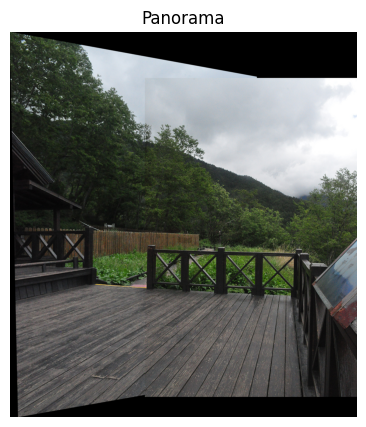

In [20]:
p = PanoramsCreator.get_panorama(PICTURE3_PATH, PICTURE4_PATH, is_print_steps=False)

 Сравните результаты выполнения операций между классом Stitcher_create из OpenCV и кастомным методом через алгоритм SIFT. Что можно улучшить в выходном результате?

 ## Доп задание*:

 Как нужно обновить написанный выше код, чтобы можно было подавать на вход более 2-ух изображения для создания панорамы?

In [21]:
PICTURE5_PATH = PICTURES_PATH + 'parrington_1.jpg'
PICTURE6_PATH = PICTURES_PATH + 'parrington_2.jpg'
PICTURE7_PATH = PICTURES_PATH + 'parrington_3.jpg'

l = [PICTURE5_PATH, PICTURE6_PATH, PICTURE7_PATH]

In [22]:
def panorama_from_many_pics(pics_path: list):
    pairs_panorams = []
    
    p1 = pics_path[0]

    for p2 in pics_path[1:]:
        pairs_panorams.append(
            PanoramsCreator.get_panorama(
                p1, p2, is_print=False, is_print_steps=False
            )
        )
        p1 = p2

    finally_panorams = pairs_panorams.copy()
    current_panorams = []
    

    while len(finally_panorams) > 1:
        panorama1 = finally_panorams[0]
        for panorama2 in finally_panorams[1:]:
            current_panorams.append(
                PanoramsCreator._custom_stitch(
                    panorama1, panorama2, is_print_steps=False
                )
            )

        finally_panorams = current_panorams
        current_panorams = []

    return finally_panorams

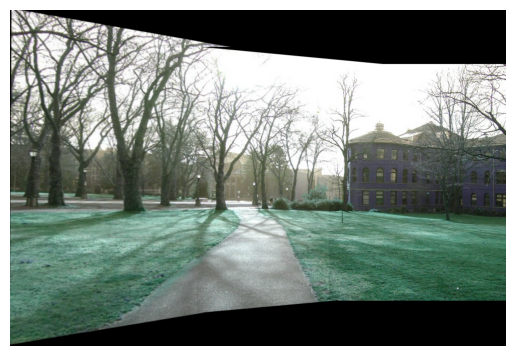

In [23]:
finally_panorama = panorama_from_many_pics(l)[0]



Shower.show_img(finally_panorama)